In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rcParams['text.usetex']         = True
rcParams['font.family']         = 'sans-serif'
rcParams['font.sans-serif']     = ['Helvetica']

In [2]:
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

### Things to add on if there is time
* error propagation (through derivatives, etc.)
* units (pint module)drops

### Universal Constants

In [3]:
frame_rate = Q_(1.0/30.0,'s') # seconds
mass_red   = None # grams
mass_base  = None # grams

mass_blue = None # grams
L = 2.0 # meters

# Ball Drop Analysis

### Data Initialization

In [4]:
### Initialize drop data
drop_data = {}
drop_data['red']  = {}
drop_data['base'] = {}

for _ in list(drop_data.keys()):
    drop_data[_]['pos'] = []
    
### Red Ball
    
drop_data['red']['pos'].append(Q_(np.array([
-5.936958196E-3,-1.783706639E-2,-3.355164627E-2,-6.482071833E-2,
-1.065598482E-1,-1.625838494E-1,-2.265381929E-1,-2.995025198E-1,
-3.880640950E-1,-4.820012928E-1,-5.901702800E-1,-7.101803071E-1,
-8.417722297E-1,-9.812655362E-1,-1.131187792E0,-1.288931383E0,
-1.463604859E0,-1.656525098E0,-1.859888688E0
]),'m'))

drop_data['red']['pos'].append(Q_(np.array([
-1.845200028E-2,-2.248757992E-2,-3.664592119E-2,-6.276491897E-2,
-1.005815509E-1,-1.488511144E-1,-2.087006494E-1,-2.791366361E-1,
-3.623878433E-1,-4.550103558E-1,-5.605537921E-1,-6.777754358E-1,
-8.055530902E-1,-9.436950147E-1,-1.090978896E0,-1.251257602E0,
-1.416770659E0,-1.605736760E0,-1.797309309E0,-2.003203811E0
]),'m'))

drop_data['red']['pos'].append(Q_(np.array([
8.694084861E-3,8.945858629E-4,-1.334832349E-2,-3.932128996E-2,
-7.818590364E-2,-1.251658226E-1,-1.846611109E-1,-2.612697346E-1,
-3.430954271E-1,-4.365466250E-1,-5.416541965E-1,-6.585605907E-1,
-7.870232695E-1,-9.233695741E-1,-1.073921059E0,-1.227107364E0,
-1.399788745E0,-1.575056790E0,-1.767145753E0,-1.948891417E0
]),'m'))

### Baseball

drop_data['base']['pos'].append(Q_(np.array([
-2.664755198E-2,-4.367235057E-2,-6.462707975E-2,
-1.011454247E-1,-1.310553813E-1,-1.935970963E-1,-2.602199722E-1,
-3.369954352E-1,-4.256249872E-1,-5.300028910E-1,-6.460000231E-1,
-7.516147643E-1,-8.819911787E-1,-1.024100135E0,-1.185734071E0,
-1.348705090E0,-1.524702426E0,-1.674635952E0,-1.876740599E0,-2.056624767E0
]),'m'))

drop_data['base']['pos'].append(Q_(np.array([
1.494029606E-2,-4.660327995E-3,-3.371800097E-2,-5.976583962E-2,
-1.093965489E-1,-1.635243614E-1,-2.423808379E-1,-3.229186144E-1,
-4.108708311E-1,-5.141070872E-1,-6.252422019E-1,-7.519278209E-1,
-8.904166982E-1,-1.035491405E0,-1.228814281E0,-1.389542590E0,
-1.534582460E0,-1.707065799E0,-1.931825282E0
]),'m'))

drop_data['base']['pos'].append(Q_(np.array([
-2.211146866E-2,-3.094413983E-2,-4.291057729E-2,-6.380538559E-2,
-9.356474780E-2,-1.403537802E-1,-1.989516002E-1,-2.653531140E-1,
-3.458360358E-1,-4.434010458E-1,-5.385375726E-1,-6.516118574E-1,
-7.817008924E-1,-9.156849628E-1,-1.063953627E0,-1.229717403E0,
-1.381908163E0,-1.560052643E0,-1.768917493E0,-1.993943144E0
]),'m'))

### Add errors
$\delta y = {\rm diameter} + 1 {\rm cm} + \sqrt{20\times{\rm frame}}$

In [5]:
def get_error(frame,which):
    if which=='red': diam=Q_(7,'cm')
    elif which=='base': diam=Q_(7.5,'cm')
    alfa = (diam/2.0)**2.0 / 20.0
    return diam / 2.0 + Q_(1.0,'cm') + np.sqrt(alfa * frame)

In [6]:
for key in drop_data.keys():
    drop_data[key]['err'] = []
    for i in range(len(drop_data[key]['pos'])):
        errors = get_error(np.arange(0,len(drop_data[key]['pos'][i])),key)
        drop_data[key]['err'].append(errors)

### Fit g
\begin{align*}
g = \sum a_i/\sigma_i^2 \Big/ \sum 1/\sigma_i^2 \\
\delta g = \left[ \sum 1/\sigma_{i}^2 \right]^{-1/2}
\end{align*}

In [61]:
def second_derivative(f,f_err):
    g    = f.magnitude
    h    = f_err.magnitude
    rate = frame_rate.magnitude
    N = len(f)
    deriv = np.zeros(N)
    error = np.zeros(N)
    deriv[0]  = (g[0] - 2*g[1] + g[2])/rate**2.0
    deriv[1]  = (g[0] - 2*g[1] + g[2])/rate**2.0
    deriv[-2] = (g[-1] - 2*g[-2] + g[-3])/rate**2.0
    deriv[-1] = (g[-1] - 2*g[-2] + g[-3])/rate**2.0
    
    error[0]  = np.sqrt(h[0]**2.0 + (2*h[1])**2.0 + h[2]**2.0)/rate**2.0
    error[1]  = np.sqrt(h[0]**2.0 + (2*h[1])**2.0 + h[2]**2.0)/rate**2.0
    error[-2] = np.sqrt(h[-1]**2.0 + (2*h[-2])**2.0 + h[-3]**2.0)/rate**2.0
    error[-1] = np.sqrt(h[-1]**2.0 + (2*h[-2])**2.0 + h[-3]**2.0)/rate**2.0
    
    for i in range(2,N-2):
        deriv[i] = (-g[i+2] + 16*g[i+1] - 30*g[i] + 16*g[i-1] - g[i-2])/12.0/rate**2.0
        error[i] = np.sqrt(h[i+2]**2.0 + (16*h[i+1])**2.0 + (30*h[i])**2.0 + (16*h[i-1]**2.0) + (g[i-2])**2.0)/12.0/rate**2.0
    return Q_(deriv,f.units/frame_rate.units**2),Q_(error,f_err.units/frame_rate.units**2)

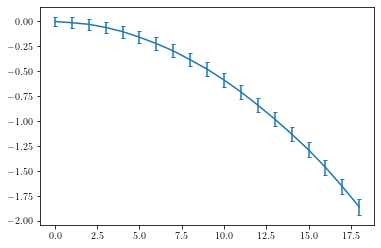

In [62]:
y  = drop_data['red']['pos'][0].magnitude
dy = drop_data['red']['err'][0].to('m').magnitude
plt.errorbar(np.arange(0,len(y)),y,yerr=dy,dash_capstyle='butt',capsize=2)
plt.show()

In [63]:
dy

array([0.045     , 0.05282624, 0.05606797, 0.05855544, 0.06065248,
       0.0625    , 0.06417029, 0.06570628, 0.06713594, 0.06847871,
       0.06974874, 0.07095669, 0.07211088, 0.0732179 , 0.0742831 ,
       0.07531089, 0.07630495, 0.07726841, 0.07820392])

In [64]:
a = second_derivative(drop_data['red']['pos'][0],drop_data['red']['err'][0])
a[0]

Magnitude,[-3.4330245174 -3.4330245174 -15.260877076799998 -8.755608437250004 -13.61908488825001 -6.579745310249954 -7.695913275000033 -15.29819026500004 -3.407225902499952 -13.652129182500063 -10.49706552749997 -10.680308489999948 -6.64563973500005 -9.771192832499889 -6.160489387499854 -15.821271885000144 -17.10610844999997 -9.39901590000014 -9.39901590000014]
Units,meter/second2


In [65]:
a[1].to('m/s**2')

Magnitude,[115.01374319109976 115.01374319109976 145.34027836399494 151.52641446617235 156.7810074224002 161.432439309 165.65129121886014 169.5400332264045 173.1660195623256 176.5763675837888 179.80558809497575 182.8798422221129 185.81955670268533 188.6410215084202 191.35748661257117 193.97989135375042 196.51741300960902 170.33537062490953 170.33537062490953]
Units,meter/second2


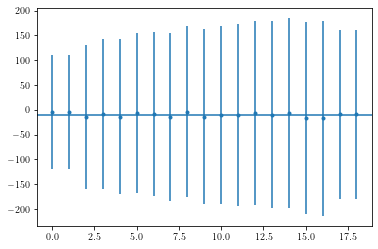

In [66]:
plt.errorbar(np.arange(0,len(a[0])),a[0].magnitude,yerr=a[1].to('m/s**2').magnitude,fmt='.')
plt.axhline(y=-9.8)
plt.show()

In [ ]:
# np.set_printoptions(precision=3)
g_fits = []
for _ in drop_data.keys():
    # print(_)
    for arr in drop_data[_]['pos']:
        v = derivative(arr)
        a = derivative(v)
        g_fits.append(fit_g(a))
g_fits = np.array(g_fits)
# print(g_fits)
# print(np.mean(g_fits))
# print(np.std(g_fits))
# print(np.std(g_fits)/np.mean(g_fits) * 100.0)
# print(abs(9.8 - np.mean(g_fits))/np.std(g_fits))
    #     print(arr)
    #     print(v)
    #     print(a)
    #     print(free_fall_best_fit(v,a))
    #     print(fit_g(a))
    #     print()
    # print()

In [75]:
-np.sum(a)/float(len(a))

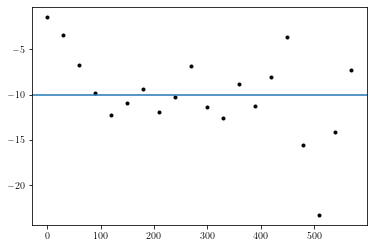

In [76]:
plt.plot(np.arange(0,len(a))/frame_rate,a,'k.')
plt.axhline(y=-10)

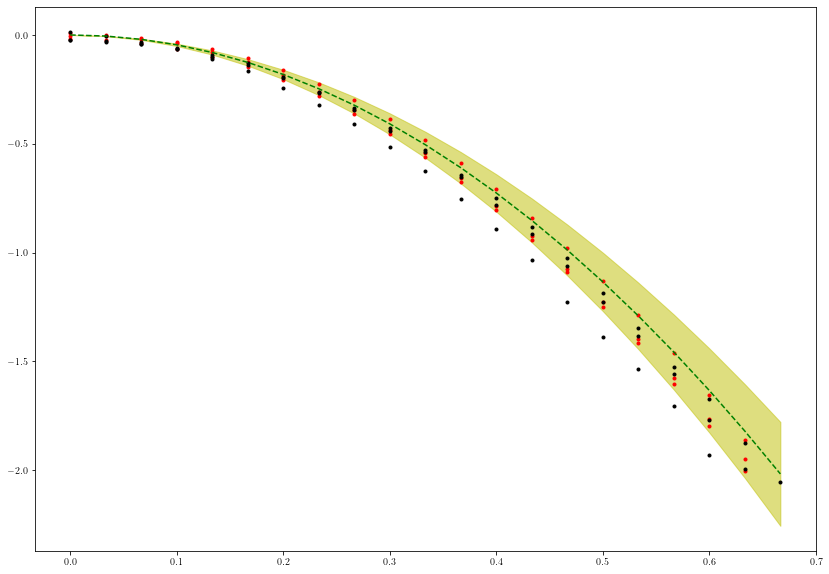

In [81]:
f = lambda g,t: -g/2.0*t**2.0

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(14,10))

max_frames = 0
for _ in drop_data.keys():
    if _ == 'red': linestyle='r.'
    if _ == 'base': linestyle='k.'
    for arr in drop_data[_]['pos']:
        if len(arr) > max_frames: max_frames = len(arr)
        ax.plot(frame_rate*np.arange(0,len(arr)),arr,linestyle)
t_vals = frame_rate*np.arange(0,max_frames)
max_vals = f(np.mean(g_fits)+np.std(g_fits),t_vals)
min_vals = f(np.mean(g_fits)-np.std(g_fits),t_vals)
ax.fill_between(t_vals,max_vals,min_vals,color='y',alpha=0.5)
ax.plot(t_vals,f(np.mean(g_fits),t_vals),'g--')
# g = lambda t: popt/2.0*t**2.0
# plt.plot(drop_data['red']['time'][0],f(drop_data['red']['time'][0]),'r-')
# plt.plot(drop_data['red']['time'][0],g(drop_data['red']['time'][0]),'c-')
plt.show()

In [56]:
vel = derivative(drop_data['red']['pos'][0],drop_data['red']['time'][0])
acc = derivative(vel,drop_data['red']['time'][0])

In [61]:
def func(t,g):
    return -g

for _ in drop_data.keys():
    for arr in drop_data[_]['pos']:
        v
        popt,pcov = curve_fit(func,np.arange(0,len(a))/len(a),a)
        print(popt)
        # print(popt[0] - 2*pcov[0][0])
        np.sqrt(np.diag(pcov))

[9.946]
[9.946]
[9.946]
[9.946]
[9.946]
[9.946]


In [ ]:
plt.plot(drop_data['red']['time'][0],vel,'k.')
plt.plot(drop_data['red']['time'][0],acc,'r.')
plt.axhline(y=popt)

In [ ]:
mean = popt[0]
err  = np.sqrt(pcov[0][0])
x = np.linspace(norm.ppf(0.01,mean,err),norm.ppf(0.99,mean,err), 100)
z = abs(mean + 9.8)/err
print(z,mean-z*err)
xp = np.linspace(mean-z*err,mean+z*err,100)
plt.plot(x,norm.pdf(x,mean,err),'k')
plt.plot(-9.8,norm.pdf(-9.8,mean,err),'yo')
plt.fill_between(xp,norm.pdf(xp,mean,err),color='red')

In [ ]:
x